# SQL

In [3]:
#To run in PostGreSQL

`postgres=#  
CREATE TABLE mytable (duration_sec NUMERIC, start_time VARCHAR(50), end_time VARCHAR(50), start_station_id NUMERIC, start_station_name VARCHAR(100), start_station_latitude NUMERIC, start_station_longitude NUMERIC, end_station_id NUMERIC, end_station_name VARCHAR(100), end_station_latitude NUMERIC, end_station_longitude NUMERIC, bike_id NUMERIC, user_type VARCHAR(25), rental_access_method VARCHAR(25));`

`COPY mytable FROM '/Users/mattranalletta/Desktop/Metis/202001-baywheels-tripdata.csv' DELIMITER ',' CSV HEADER;`

In [4]:
# Back in Jupyter

In [5]:
import psycopg2 as pg

In [6]:
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'postgres',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [8]:
query = "SELECT * FROM mytable"

bw_sql = pd.read_sql(query, connection)
bw_sql.shape

(124854, 14)

# Exploratory Data Analysis and Cleaning

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean as euc
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

Let's import the first two datasets.

In [121]:
bw = pd.read_csv('202001-baywheels-tripdata.csv',low_memory=False)
transit_info = pd.read_csv('Bikeshare_transit.csv',low_memory=False)

In [122]:
bw.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method
0,787,1/12/20 17:07,1/12/20 17:20,451.0,10th Ave at Irving St,37.764091,-122.467378,451.0,10th Ave at Irving St,37.764091,-122.467378,520485,Subscriber,app
1,543,1/25/20 17:37,1/25/20 17:46,466.0,5th Ave at Anza St,37.779488,-122.463142,451.0,10th Ave at Irving St,37.764091,-122.467378,713870,Subscriber,app
2,1860,1/10/20 19:33,1/10/20 20:04,440.0,Carl St at Cole St,37.765910,-122.449257,451.0,10th Ave at Irving St,37.764091,-122.467378,113372,Customer,app
3,1601,1/22/20 13:36,1/22/20 14:03,17.0,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,451.0,10th Ave at Irving St,37.764091,-122.467378,394499,Subscriber,app
4,337,1/12/20 7:24,1/12/20 7:30,458.0,Frederick St at Arguello Blvd,37.765783,-122.457637,451.0,10th Ave at Irving St,37.764091,-122.467378,456732,Subscriber,app


Dropping and renaming columns:

In [123]:
bw.drop(['start_station_id','end_station_id','bike_id'],
        axis=1, inplace=True)
bw.columns = ['duration_sec','start_time','end_time','start_station_name', 'start_lat','start_long','end_station_name',
              'end_lat','end_long','user_type','access_method']
bw.head()

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,access_method
0,787,1/12/20 17:07,1/12/20 17:20,10th Ave at Irving St,37.764091,-122.467378,10th Ave at Irving St,37.764091,-122.467378,Subscriber,app
1,543,1/25/20 17:37,1/25/20 17:46,5th Ave at Anza St,37.779488,-122.463142,10th Ave at Irving St,37.764091,-122.467378,Subscriber,app
2,1860,1/10/20 19:33,1/10/20 20:04,Carl St at Cole St,37.765910,-122.449257,10th Ave at Irving St,37.764091,-122.467378,Customer,app
3,1601,1/22/20 13:36,1/22/20 14:03,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,10th Ave at Irving St,37.764091,-122.467378,Subscriber,app
4,337,1/12/20 7:24,1/12/20 7:30,Frederick St at Arguello Blvd,37.765783,-122.457637,10th Ave at Irving St,37.764091,-122.467378,Subscriber,app


In [124]:
transit_info.head()

,ADDRESS,CITY,ZIPCODE,LONGITUDE,LATITUDE,MODES_SERV,MODE_BUS,MODE_RAIL,MODE_FERRY
0,Post St at Kearny St,San Francisco,94104,-122.403452,37.788975,3,"Bus (transit, intercity, supplemental, or code...","Rail (intercity, heavy, light, or commuter) se...",No ferry (intercity or transit) service available
1,Montgomery St BART Station (Market St at 2nd St),San Francisco,94105,-122.400811,37.789625,3,"Bus (transit, intercity, supplemental, or code...","Rail (intercity, heavy, light, or commuter) se...",No ferry (intercity or transit) service available
2,San Francisco Ferry Building (Harry Bridges Pl...,San Francisco,94111,-122.394203,37.795392,4,"Bus (transit, intercity, supplemental, or code...","Rail (intercity, heavy, light, or commuter) se...",Ferry (intercity or transit) service is available
3,San Francisco Caltrain (Townsend St at 4th St),San Francisco,94107,-122.395282,37.776598,3,"Bus (transit, intercity, supplemental, or code...","Rail (intercity, heavy, light, or commuter) se...",No ferry (intercity or transit) service available
4,Embarcadero BART Station (Beale St at Market St),San Francisco,94105,-122.397086,37.792251,3,"Bus (transit, intercity, supplemental, or code...","Rail (intercity, heavy, light, or commuter) se...",No ferry (intercity or transit) service available


On the transit info data, let's rename the columns and then get replace the blanks with NaN values.

In [125]:
transit_info.columns = ['station_name','city','zip','latitude','longitude','transit_modes','bus','rail','ferry']
transit_info = transit_info.replace(r'^\s*$', np.NaN, regex=True)

In [126]:
transit_info.shape

(408, 9)

Now I'll rename the bus, rail, and ferry columns to something simpler.

In [127]:
transit_info.bus.value_counts()

Bus (transit, intercity, supplemental, or code-share) service is available    280
No bus (transit, intercity, supplemental, or code-share) service available    128
Name: bus, dtype: int64

In [128]:
replace_bus_values = {'Bus (transit, intercity, supplemental, or code-share) service is available' : 1, 
                      'No bus (transit, intercity, supplemental, or code-share) service available' : 0}
transit_info = transit_info.replace({"bus": replace_bus_values})

In [129]:
transit_info.rail.value_counts()

No rail (intercity, heavy, light, or commuter) service available    339
Rail (intercity, heavy, light, or commuter) service is available     69
Name: rail, dtype: int64

In [130]:
replace_rail_values = {'Rail (intercity, heavy, light, or commuter) service is available' : 1, 
                      'No rail (intercity, heavy, light, or commuter) service available' : 0}
transit_info = transit_info.replace({"rail": replace_rail_values})

In [131]:
transit_info.ferry.value_counts()

No ferry (intercity or transit) service available    406
Ferry (intercity or transit) service is available      2
Name: ferry, dtype: int64

In [132]:
replace_ferry_values = {'Ferry (intercity or transit) service is available' : 1, 
                      'No ferry (intercity or transit) service available' : 0}
transit_info = transit_info.replace({"ferry": replace_ferry_values})

In [133]:
transit_info['transit_modes'] = transit_info['transit_modes'] - 1
transit_info.dropna(axis=0,inplace=True)
transit_info.head()

,station_name,city,zip,latitude,longitude,transit_modes,bus,rail,ferry
0,Post St at Kearny St,San Francisco,94104,-122.403452,37.788975,2,1,1,0
1,Montgomery St BART Station (Market St at 2nd St),San Francisco,94105,-122.400811,37.789625,2,1,1,0
2,San Francisco Ferry Building (Harry Bridges Pl...,San Francisco,94111,-122.394203,37.795392,3,1,1,1
3,San Francisco Caltrain (Townsend St at 4th St),San Francisco,94107,-122.395282,37.776598,2,1,1,0
4,Embarcadero BART Station (Beale St at Market St),San Francisco,94105,-122.397086,37.792251,2,1,1,0


That looks much better. Now I'm ready to merge the first two dataframes based on station name, which has a consistent naming convention between the two.

In [134]:
bw['start_zip'] = bw['start_station_name'].map(transit_info.set_index('station_name')['zip'])
bw['end_zip'] = bw['end_station_name'].map(transit_info.set_index('station_name')['zip'])
bw['start_transit'] = bw['start_station_name'].map(transit_info.set_index('station_name')['transit_modes'])
bw['end_transit'] = bw['end_station_name'].map(transit_info.set_index('station_name')['transit_modes'])
bw['start_city'] = bw['start_station_name'].map(transit_info.set_index('station_name')['city'])
bw['end_city'] = bw['end_station_name'].map(transit_info.set_index('station_name')['city'])

bw['is_subscriber'] = bw.user_type.replace(to_replace=['Customer', 'Subscriber'], value=[0, 1])

I'm also going to calculate a new column for Manhattan distance, which is the difference between the starting and ending latitude and longitude points, added together.

In [135]:
bw['lat_diff'] = bw['start_lat'] - bw['end_lat']
bw['long_diff'] = bw['start_long'] - bw['end_long']
bw['manhattan_dist'] = np.abs(bw['lat_diff']) + np.abs(bw['long_diff'])

In [136]:
bw.head()

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,...,start_zip,end_zip,start_transit,end_transit,start_city,end_city,is_subscriber,lat_diff,long_diff,manhattan_dist
0,787,1/12/20 17:07,1/12/20 17:20,10th Ave at Irving St,37.764091,-122.467378,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0.000000,0.000000,0.000000
1,543,1/25/20 17:37,1/25/20 17:46,5th Ave at Anza St,37.779488,-122.463142,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0.015397,0.004237,0.019633
2,1860,1/10/20 19:33,1/10/20 20:04,Carl St at Cole St,37.765910,-122.449257,10th Ave at Irving St,37.764091,-122.467378,Customer,...,94117.0,NaN,2.0,NaN,San Francisco,NaN,0,0.001819,0.018121,0.019940
3,1601,1/22/20 13:36,1/22/20 14:03,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,94105.0,NaN,2.0,NaN,San Francisco,NaN,1,0.028160,0.070292,0.098452
4,337,1/12/20 7:24,1/12/20 7:30,Frederick St at Arguello Blvd,37.765783,-122.457637,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0.001692,0.009742,0.011434


In [137]:
bw.manhattan_dist.value_counts(ascending=False)

0.000000    3568
0.011965     428
0.020545     396
0.019672     365
0.018556     347
            ... 
0.006098       1
0.017827       1
0.021067       1
0.063860       1
0.082631       1
Name: manhattan_dist, Length: 15722, dtype: int64

I want to get rid of the 3,568 rows with 0.0 values for Manhattan distance. I think it's a pretty important metric for this project.

In [138]:
mask = bw[(bw['manhattan_dist'] == 0.0)].index
bw.drop(mask, inplace=True)

In [139]:
bw.start_city.value_counts(ascending=False)

San Francisco    67178
Oakland          14667
Berkeley         11695
San Jose          4462
Emeryville        2039
New York            24
Name: start_city, dtype: int64

Why is New York in there? No idea, but let's get rid of it in both the `start_city` and `end_city` columns.

In [140]:
mask = bw[(bw['start_city'] == 'New York')].index
bw.drop(mask, inplace=True)

In [141]:
bw.end_city.value_counts(ascending=False)

San Francisco    66876
Oakland          15005
Berkeley         11221
San Jose          3883
Emeryville        2277
New York            27
Name: end_city, dtype: int64

In [142]:
mask = bw[(bw['end_city'] == 'New York')].index
bw.drop(mask, inplace=True)

Our third and final dataframe is a json file I got from the General Bikeshare Feed Specification, linked from the site where I got Lyft's Bay Wheels ridership data.

In [143]:
station_info = pd.read_json('station_information.json')
station_info.head(3)

,name,capacity,lon,legacy_id,lat,electric_bike_surcharge_waiver,short_name,region_id,external_id,eightd_has_key_dispenser,eightd_station_services,station_id,has_kiosk,station_type,rental_methods,rental_uris
0,Powell St BART Station (Market St at 4th St),35,-122.404904,3,37.786375,False,SF-G27,3.0,1b13a386-c5f4-42cc-bc3b-ded95982e090,False,[],3,True,classic,"[KEY, CREDITCARD]","{'ios': 'https://sfo.lft.to/lastmile_qr_scan',..."
1,Cyril Magnin St at Ellis St,35,-122.408923,4,37.785876,False,SF-G26,3.0,a00d04e6-0159-466a-b3ab-23f9550f418c,False,[],4,True,classic,"[KEY, CREDITCARD]","{'ios': 'https://sfo.lft.to/lastmile_qr_scan',..."
2,Powell St BART Station (Market St at 5th St),35,-122.408445,5,37.783899,False,SF-H26,3.0,a1e0b4b2-2c5c-4201-a78c-9e8a2152ab4e,False,[],5,True,classic,"[KEY, CREDITCARD]","{'ios': 'https://sfo.lft.to/lastmile_qr_scan',..."


Let's drop the columns I don't care about.

In [144]:
station_info.drop(['legacy_id', 'electric_bike_surcharge_waiver','short_name','region_id','external_id','eightd_has_key_dispenser','eightd_station_services','station_id',
                   'has_kiosk','station_type','rental_methods','rental_uris'],axis=1, inplace=True)
station_info.head(5)

,name,capacity,lon,lat
0,Powell St BART Station (Market St at 4th St),35,-122.404904,37.786375
1,Cyril Magnin St at Ellis St,35,-122.408923,37.785876
2,Powell St BART Station (Market St at 5th St),35,-122.408445,37.783899
3,The Embarcadero at Sansome St,23,-122.403234,37.804770
4,Frank H Ogawa Plaza,19,-122.271738,37.804562


And join this clean dataframe to the previously merged `bw` dataframe.

In [145]:
bw['start_cap'] = bw['start_station_name'].map(station_info.set_index('name')['capacity'])
bw['end_cap'] = bw['end_station_name'].map(station_info.set_index('name')['capacity'])

In [146]:
bw.head()

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,...,start_transit,end_transit,start_city,end_city,is_subscriber,lat_diff,long_diff,manhattan_dist,start_cap,end_cap
1,543,1/25/20 17:37,1/25/20 17:46,5th Ave at Anza St,37.779488,-122.463142,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,1,0.015397,0.004237,0.019633,21.0,23.0
2,1860,1/10/20 19:33,1/10/20 20:04,Carl St at Cole St,37.765910,-122.449257,10th Ave at Irving St,37.764091,-122.467378,Customer,...,2.0,NaN,San Francisco,NaN,0,0.001819,0.018121,0.019940,23.0,23.0
3,1601,1/22/20 13:36,1/22/20 14:03,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,2.0,NaN,San Francisco,NaN,1,0.028160,0.070292,0.098452,27.0,23.0
4,337,1/12/20 7:24,1/12/20 7:30,Frederick St at Arguello Blvd,37.765783,-122.457637,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,1,0.001692,0.009742,0.011434,19.0,23.0
5,656,1/20/20 16:19,1/20/20 16:30,Frederick St at Arguello Blvd,37.765783,-122.457637,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,1,0.001692,0.009742,0.011434,19.0,23.0


In [147]:
bw.shape

(121235, 23)

In [148]:
bw.user_type.value_counts()

Customer      99897
Subscriber    21338
Name: user_type, dtype: int64

In [149]:
bw.start_transit.value_counts()

1.0    48791
0.0    29726
2.0    19975
3.0     1526
Name: start_transit, dtype: int64

We don't need lat_diff and long_diff anymore since I calculated Manhattan distance from these two columns.

In [150]:
bw.drop(['lat_diff','long_diff'],axis=1, inplace=True)
bw.head()

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,...,start_zip,end_zip,start_transit,end_transit,start_city,end_city,is_subscriber,manhattan_dist,start_cap,end_cap
1,543,1/25/20 17:37,1/25/20 17:46,5th Ave at Anza St,37.779488,-122.463142,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0.019633,21.0,23.0
2,1860,1/10/20 19:33,1/10/20 20:04,Carl St at Cole St,37.765910,-122.449257,10th Ave at Irving St,37.764091,-122.467378,Customer,...,94117.0,NaN,2.0,NaN,San Francisco,NaN,0,0.019940,23.0,23.0
3,1601,1/22/20 13:36,1/22/20 14:03,Embarcadero BART Station (Beale St at Market St),37.792251,-122.397086,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,94105.0,NaN,2.0,NaN,San Francisco,NaN,1,0.098452,27.0,23.0
4,337,1/12/20 7:24,1/12/20 7:30,Frederick St at Arguello Blvd,37.765783,-122.457637,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0.011434,19.0,23.0
5,656,1/20/20 16:19,1/20/20 16:30,Frederick St at Arguello Blvd,37.765783,-122.457637,10th Ave at Irving St,37.764091,-122.467378,Subscriber,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0.011434,19.0,23.0


I'm now going to drop null values for the station names so I can do the `applymap()` below, and I'll also drop nulls for zip codes, transit, and capacity columns, since those are my main secondary sources of data.

In [151]:
bw.dropna(subset=['start_station_name','end_station_name','start_zip', 'end_zip', 'start_transit', 'end_transit', 'start_cap', 'end_cap'],inplace=True)

In [152]:
bw.shape

(81488, 21)

In [153]:
bw.start_city.value_counts(ascending=False)

San Francisco    50261
Oakland          14310
Berkeley         11337
San Jose          3590
Emeryville        1990
Name: start_city, dtype: int64

I want to remove the .0 from the integers in the zip, transit, and capacity columns:

In [154]:
cols = ['start_zip', 'end_zip', 'start_transit', 'end_transit', 'start_cap', 'end_cap']
bw[cols] = bw[cols].applymap(np.int64)
bw.head()

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,...,start_zip,end_zip,start_transit,end_transit,start_city,end_city,is_subscriber,manhattan_dist,start_cap,end_cap
9,840,1/21/20 18:04,1/21/20 18:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
10,613,1/17/20 18:49,1/17/20 19:00,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
11,884,1/14/20 18:07,1/14/20 18:22,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
15,1171,1/29/20 17:12,1/29/20 17:32,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23
16,1401,1/8/20 18:55,1/8/20 19:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23


In [155]:
bw.reset_index(drop=True,inplace=True)

In [156]:
bw.head()

,duration_sec,start_time,end_time,start_station_name,start_lat,start_long,end_station_name,end_lat,end_long,user_type,...,start_zip,end_zip,start_transit,end_transit,start_city,end_city,is_subscriber,manhattan_dist,start_cap,end_cap
0,840,1/21/20 18:04,1/21/20 18:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
1,613,1/17/20 18:49,1/17/20 19:00,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
2,884,1/14/20 18:07,1/14/20 18:22,San Jose Diridon Station,37.329732,-121.901782,10th St at Empire St,37.349426,-121.887619,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.033857,35,23
3,1171,1/29/20 17:12,1/29/20 17:32,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23
4,1401,1/8/20 18:55,1/8/20 19:18,San Jose Diridon Station,37.329732,-121.901782,10th St at Mission St,37.355693,-121.892251,Subscriber,...,95110,95112,2,1,San Jose,San Jose,1,0.035492,35,23


In [157]:
bw.shape

(81488, 21)

Still over 81,000 rows of data. Let's plot them.

/Users/mattranalletta/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


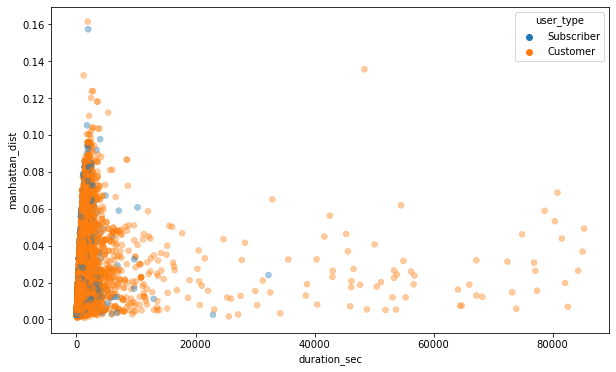

In [158]:
sns.scatterplot('duration_sec', 'manhattan_dist', data=bw, alpha=.4, hue='user_type', edgecolor=None)
plt.gcf().set_size_inches(10,6);

Looks like a pretty big class imbalance. Let's find out by how much.

In [159]:
type_count = bw.user_type.value_counts()

In [160]:
print(f'Customer: {type_count[0]}')
print(f'Subscriber: {type_count[1]}')
print(f'Proportion: {round(type_count[0] / type_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(type_count[0] / sum(type_count), 4)*100}')

Customer: 68128
Subscriber: 13360
Proportion: 5.1 : 1
Percentage of Majority Class: 83.6


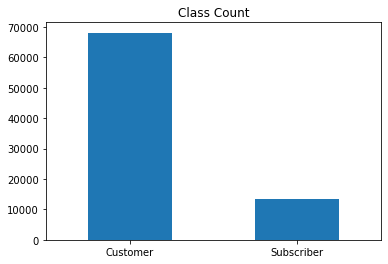

In [161]:
type_count.plot(kind='bar', title='Class Count', rot=0);

I want to get rid of some outliers from the scatterplot above, so I'm going to set boundaries for the data:

In [162]:
bw = bw[bw['duration_sec'] < 15000]
bw = bw[bw['manhattan_dist'] < 0.12]

/Users/mattranalletta/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


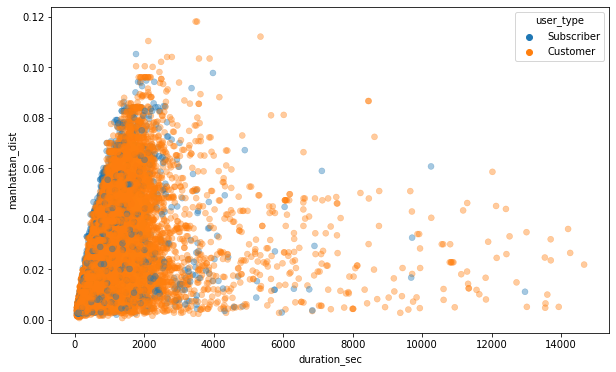

In [163]:
sns.scatterplot('duration_sec', 'manhattan_dist', data=bw, alpha=.4, hue='user_type', edgecolor=None)
plt.gcf().set_size_inches(10,6);

In [164]:
bw.shape

(81389, 21)

Looks a lot better, and still only got rid of about 100 values.

(Editor's note, after completing this project: I probably could have gotten rid of even more data, since 14,000 seconds is about 3.88 hours, which is a long time to be on a rented bike share bike, especially since only the first 30 or 45 minutes are a flat rate, depending on membership status. I would probably redo this and cut off everything at 7,200 seconds, which is two hours.)

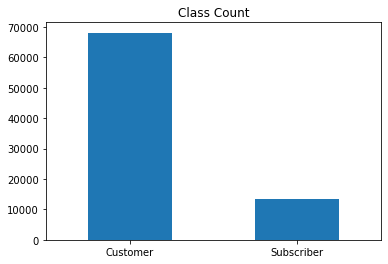

In [135]:
type_count.plot(kind='bar', title='Class Count', rot=0);

Let's pickle the dataframe to now start our classification process.

In [136]:
import pickle
bw.to_pickle('bw.pkl')